# Test getting the width of the nanobeam

First attempts to understand how to extract the width of the nanobeams. This notebook
will be a test before moving it to a standalone Python file.

In [1]:
import sys
sys.path.insert(0, "../ellipsefinder/")

from preprocess.rmbanner import remove_banner
from find_ellipses import get_pixel_size

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import widgets
from typing import List, Dict, Tuple
from itertools import combinations

# 1: Image `../images/a90l90__q002/a90l90__q002.jpg`

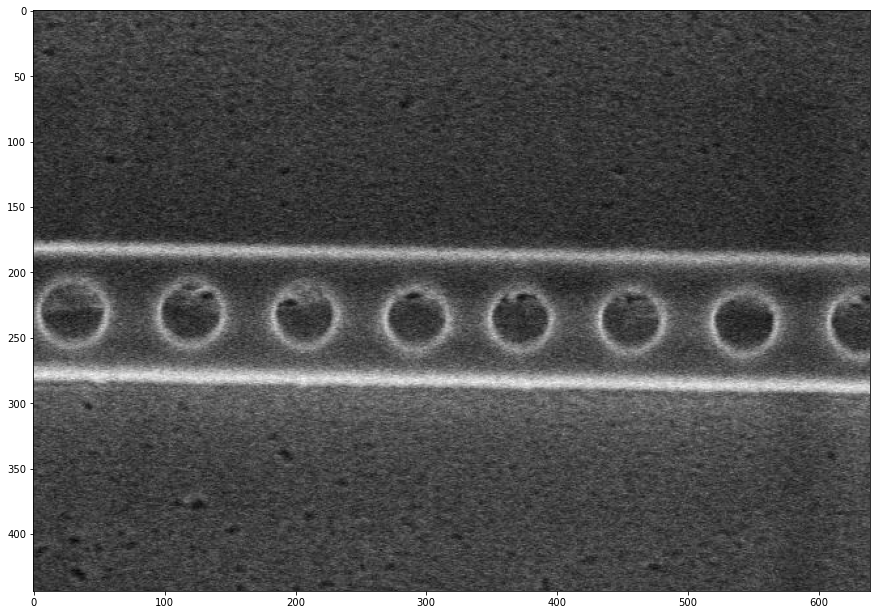

In [2]:
filename = "../images/a90l90__q002/a90l90__q002.jpg"

# Load image
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# Remove banner
no_banner, loc = remove_banner(img, invert=True)

# Display image
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(no_banner, cmap="gray")

## Attempt 1

Not even close

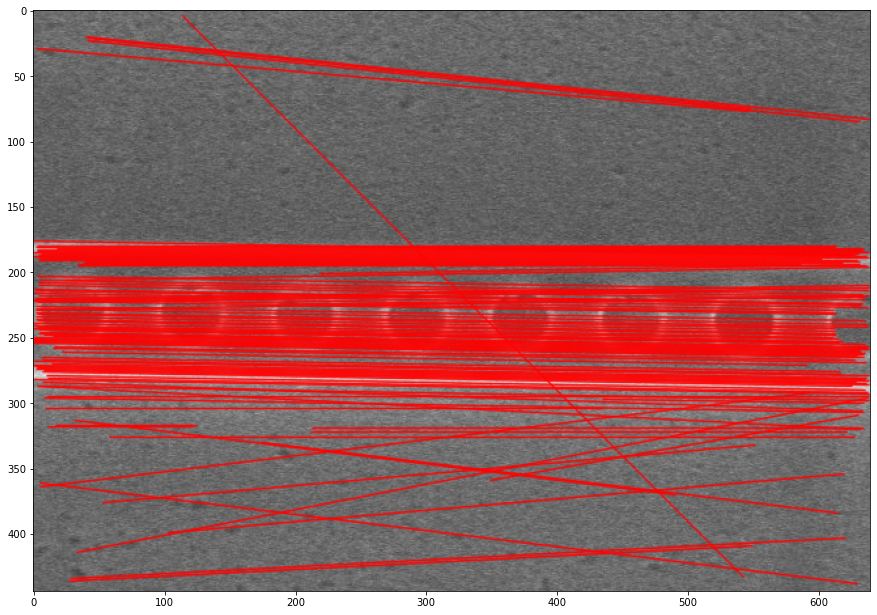

In [3]:
edges = cv2.Canny(no_banner, 50, 150, apertureSize=3)

minLineLength=100
lines = cv2.HoughLinesP(
    image = edges,
    rho = 1,
    theta = np.pi/180, 
    threshold = 100,
    lines = np.array([]), 
    minLineLength = minLineLength,
    maxLineGap = 80
)

# Copy input and convert to RGB
output = cv2.cvtColor(no_banner, cv2.COLOR_GRAY2RGB)

# Draw lines
a,b,c = lines.shape
for i in range(a):
    cv2.line(output, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255, 0, 0), 1, cv2.LINE_AA)
    

# Display image
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(output, cmap="gray")

## Attempt 2

At least the lines are somewhat closer

lines: 15


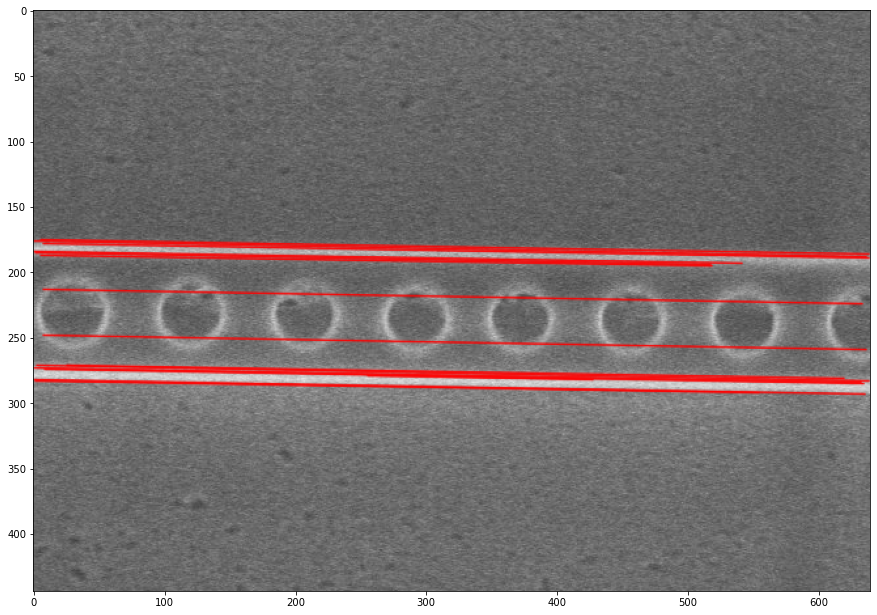

In [50]:
# Remove noise
no_noise = cv2.medianBlur(no_banner, 3)

edges = cv2.Canny(no_noise, 50, 150, apertureSize=3)

minLineLength=100
lines = cv2.HoughLinesP(
    image = edges,
    rho = 1,
    theta = np.pi/180, 
    threshold = 100,
    lines = np.array([]), 
    minLineLength = minLineLength,
    maxLineGap = 80
)

# Copy input and convert to RGB
output = cv2.cvtColor(no_banner, cv2.COLOR_GRAY2RGB)

# Draw lines
a,b,c = lines.shape
for i in range(a):
    cv2.line(output, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255, 0, 0), 1, cv2.LINE_AA)
print("lines:", a)

# Display image
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(output, cmap="gray")

## Attempt 3

Better still, still some rogue lines

lines: 15


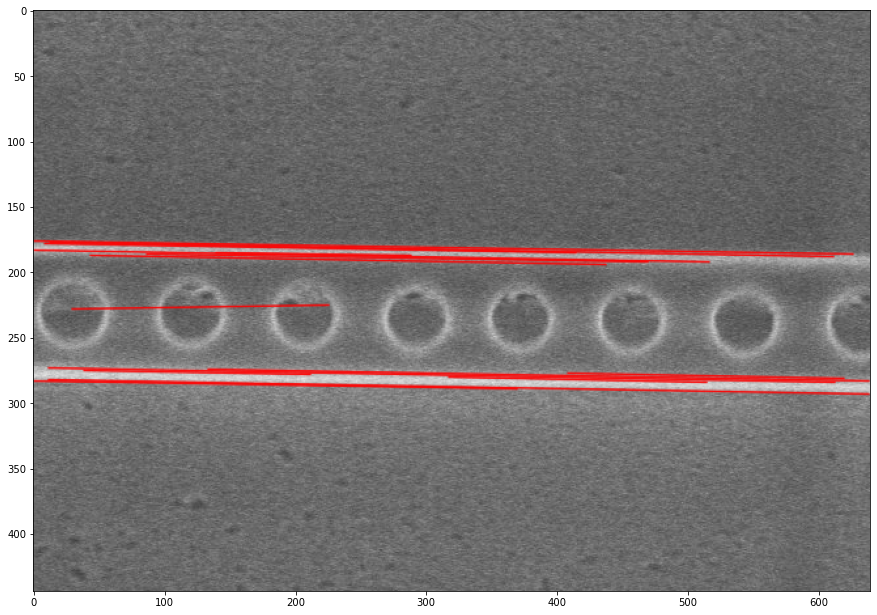

In [3]:
# Exaggerate straight lines
linek = np.zeros((11, 11), dtype=np.uint8)
linek[linek.shape[0] // 2, :] = 1
straight = cv2.morphologyEx(no_banner, cv2.MORPH_OPEN, linek)

# Canny edge detection
edges = cv2.Canny(straight, 50, 150, apertureSize=3)

# Find straight line from the edges
minLineLength=100
lines = cv2.HoughLinesP(
    image = edges,
    rho = 1,
    theta = np.pi/180, 
    threshold = 100,
    lines = np.array([]), 
    minLineLength = minLineLength,
    maxLineGap = 80
)

# Copy input and convert to RGB
output = cv2.cvtColor(no_banner, cv2.COLOR_GRAY2RGB)

# Draw lines
a,b,c = lines.shape
for i in range(a):
    cv2.line(output, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255, 0, 0), 1, cv2.LINE_AA)
print("lines:", a)


# Display image
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(output, cmap="gray")

## Attempt 3.5

lines: 7


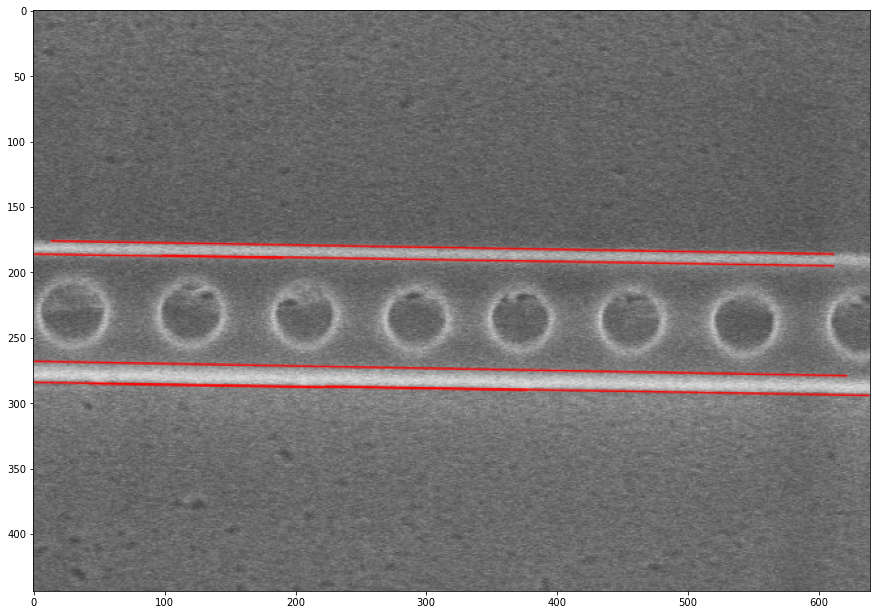

In [3]:
# Exaggerate long straight lines
linek = np.zeros((15, 15), dtype=np.uint8)
linek[linek.shape[0] // 2, :] = 1
straight = cv2.morphologyEx(no_banner, cv2.MORPH_OPEN, linek, iterations=3)


pre = cv2.GaussianBlur(straight, (7, 7), 0)
pre = cv2.fastNlMeansDenoising(pre, None, 10, 7, 21)

ret, pre = cv2.threshold(pre, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Canny edge detection
edges = cv2.Canny(pre, 50, 150, apertureSize=3)

# Find straight line from the edges
minLineLength=100
lines = cv2.HoughLinesP(
    image = edges,
    rho = 1,
    theta = np.pi/180, 
    threshold = 100,
    lines = np.array([]), 
    minLineLength = minLineLength,
    maxLineGap = 80
)

# Copy input and convert to RGB
output = cv2.cvtColor(no_banner, cv2.COLOR_GRAY2RGB)

# Draw lines
a,b,c = lines.shape
for i in range(a):
    cv2.line(output, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255, 0, 0), 1, cv2.LINE_AA)
print("lines:", a)


# Display image
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(output, cmap="gray")

## Attempt 4

Best attempt yet

lines: 8


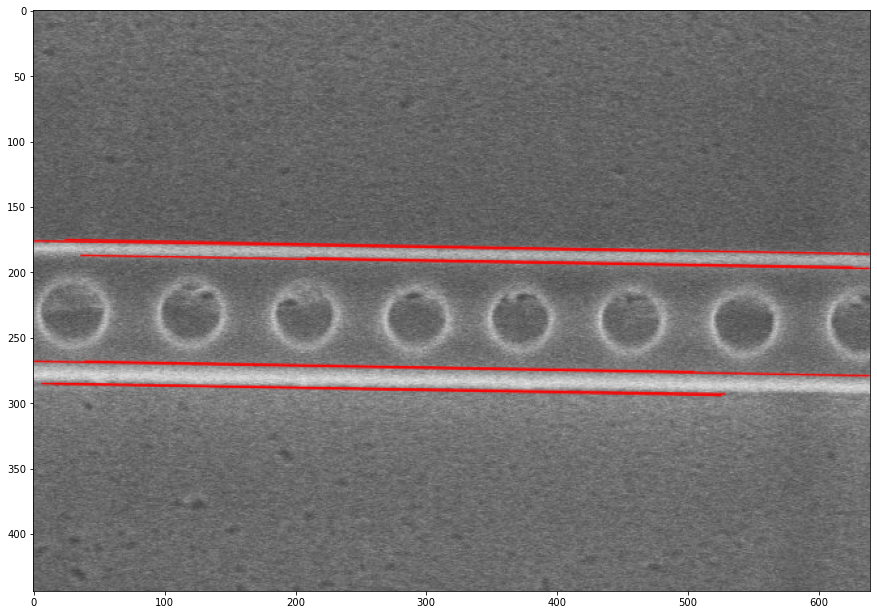

In [38]:
def get_lines(img, return_pre=False, return_edges=False):
    # Denoise image
    pre = img.copy()
    pre = cv2.GaussianBlur(pre, (7, 7), 0)
    pre = cv2.fastNlMeansDenoising(pre, None, 10, 7, 21)

    # Otsu threshold
    ret, pre = cv2.threshold(pre, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Canny edge detection
    edges = cv2.Canny(pre, 50, 150, apertureSize=3)

    # Find straight line from the edges
    minLineLength=100
    lines = cv2.HoughLinesP(
        image = edges,
        rho = 1,
        theta = np.pi/180, 
        threshold = 100,
        lines = np.array([]), 
        minLineLength = minLineLength,
        maxLineGap = 80
    )

    # Copy input and convert to RGB
    output = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Draw lines
    a,b,c = lines.shape
    for i in range(a):
        cv2.line(output, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255, 0, 0), 1, cv2.LINE_AA)

    ret = [lines, output]
    if return_pre:
        ret.append(pre)
    if return_edges:
        ret.append(edges)
    
    return ret

lines, output = get_lines(no_banner)
print("lines:", len(lines))

# Display image
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(output, cmap="gray")

# 2: Image `../images/a90l90-001/a90l90-001.tif`

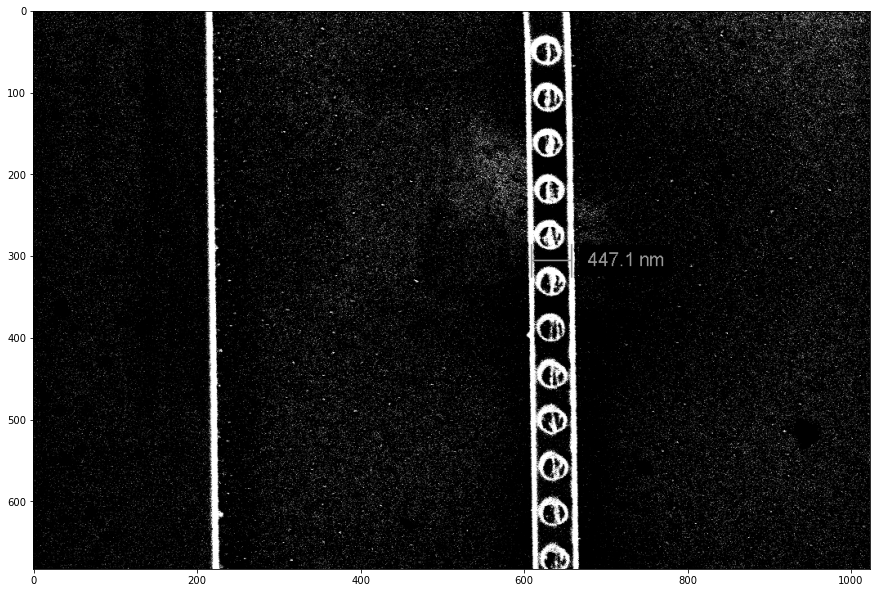

In [23]:
filename = "../images/a90l90-001/a90l90-001.tif"

# Load image
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# Remove banner
no_banner, loc = remove_banner(img, invert=False)

# Display image
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(no_banner, cmap="gray")

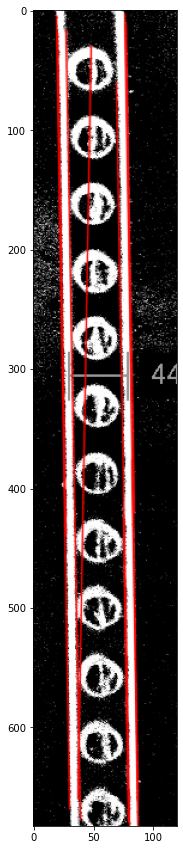

In [14]:
lines, output, pre, edges = get_lines(no_banner[:, 580:700], return_pre=True, return_edges=True)

# Display image
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(output, cmap="gray")

# Line Organization

In [4]:
# Convert line segments to lines and return their slopes and intercepts

def get_line_parameters(lines):
    m_arr = np.zeros(len(lines))
    b_arr = np.zeros(len(lines))
    for (i, line) in enumerate(lines):
        x1, y1, x2, y2 = line.flatten()

        # Calculate slope and intercept
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1

        # Add to list
        m_arr[i] = m
        b_arr[i] = b
    
    return m_arr, b_arr

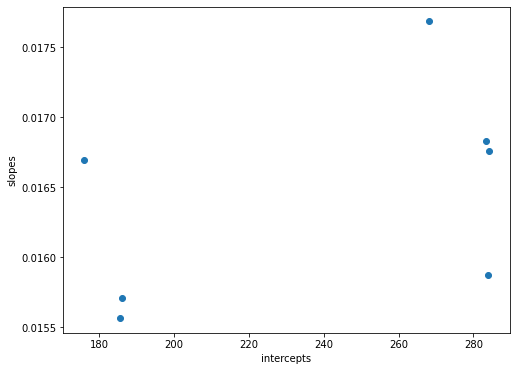

In [5]:
# Get slopes and intercepts from the lines output from before

m, b = get_line_parameters(lines)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_ylabel("slopes")
ax.set_xlabel("intercepts")
ax.scatter(b, m)

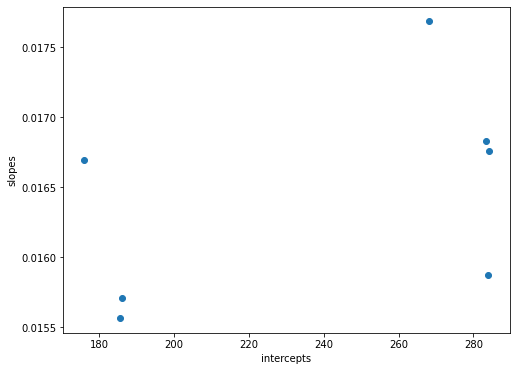

In [6]:
# Attempt to remove outliers using Interquartile Range on slopes
def remove_outliers(m, b):
    q1 = np.percentile(m, 25)
    q3 = np.percentile(m, 75)
    iqr = q3 - q1
    outlier_thresh = iqr * 1.5
    inlier_mask = (m < q3 + outlier_thresh) & (m > q1 - outlier_thresh)
    m = m[inlier_mask]
    b = b[inlier_mask]
    return m, b

m_inliers, b_inliers = remove_outliers(m, b)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_ylabel("slopes")
ax.set_xlabel("intercepts")
ax.scatter(b_inliers, m_inliers)

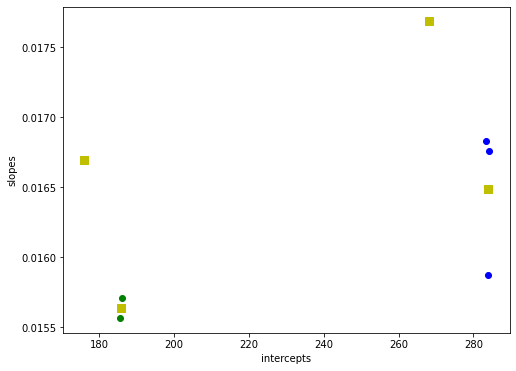

In [7]:
Z = np.vstack((m_inliers, b_inliers))
Z = np.float32(Z).T

# Define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)
ret, label, center = cv2.kmeans(Z, 4, None, criteria, 100, cv2.KMEANS_RANDOM_CENTERS)

# Sort centers by y-intercept
center_sorted = center[center[:, 1].argsort()]

fig, ax = plt.subplots(figsize=(8, 6))
colors = {0: "r", 1: "g", 2: "b", 3: "c"}

# Plot labels data points
for i in range(len(label)):
    cls = label[i, 0]
    x, y = Z[i]

    ax.scatter(y, x, c=colors[cls])

# Plot centroids
ax.scatter(center[:, 1], center[:, 0], s=80, c="y", marker="s")

ax.set_xlabel("intercepts")
ax.set_ylabel("slopes")

plt.show()

In [8]:
def plot_lines(centroids, img):
    output = img.copy()
    if len(output.shape) != 3:
        output = cv2.cvtColor(output, cv2.COLOR_GRAY2RGB)
    
    height, width, depth = output.shape

    for (m, b) in centroids:
        y = lambda x: round(m * x + b)
        cv2.line(output, (0, y(0)), (width, y(width)), (255, 0, 0), 1, cv2.LINE_AA)
        
    return output

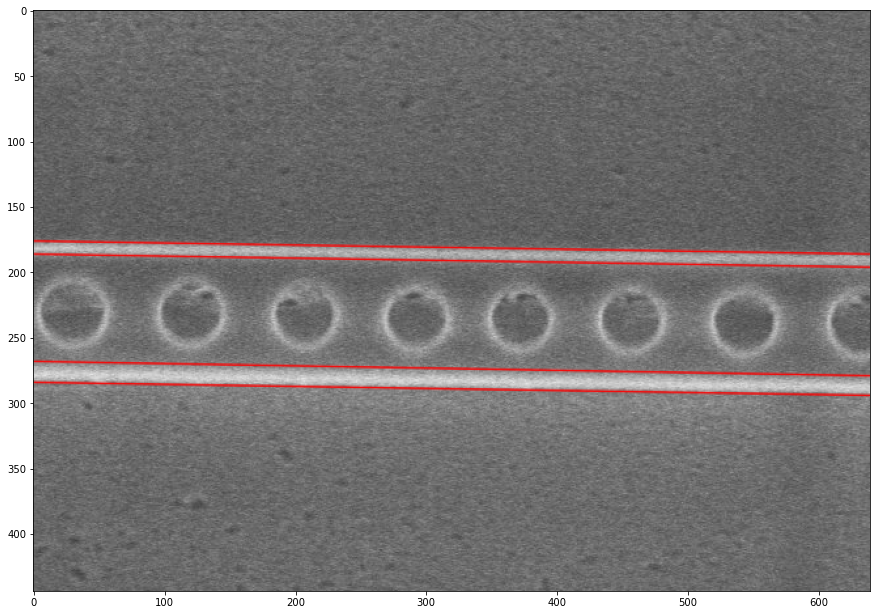

In [9]:
output_lines = plot_lines(center, no_banner)
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(output_lines, cmap="gray")

# Line Fine Tuning

In [10]:
# Reset Matplotlib back to inline
%matplotlib inline

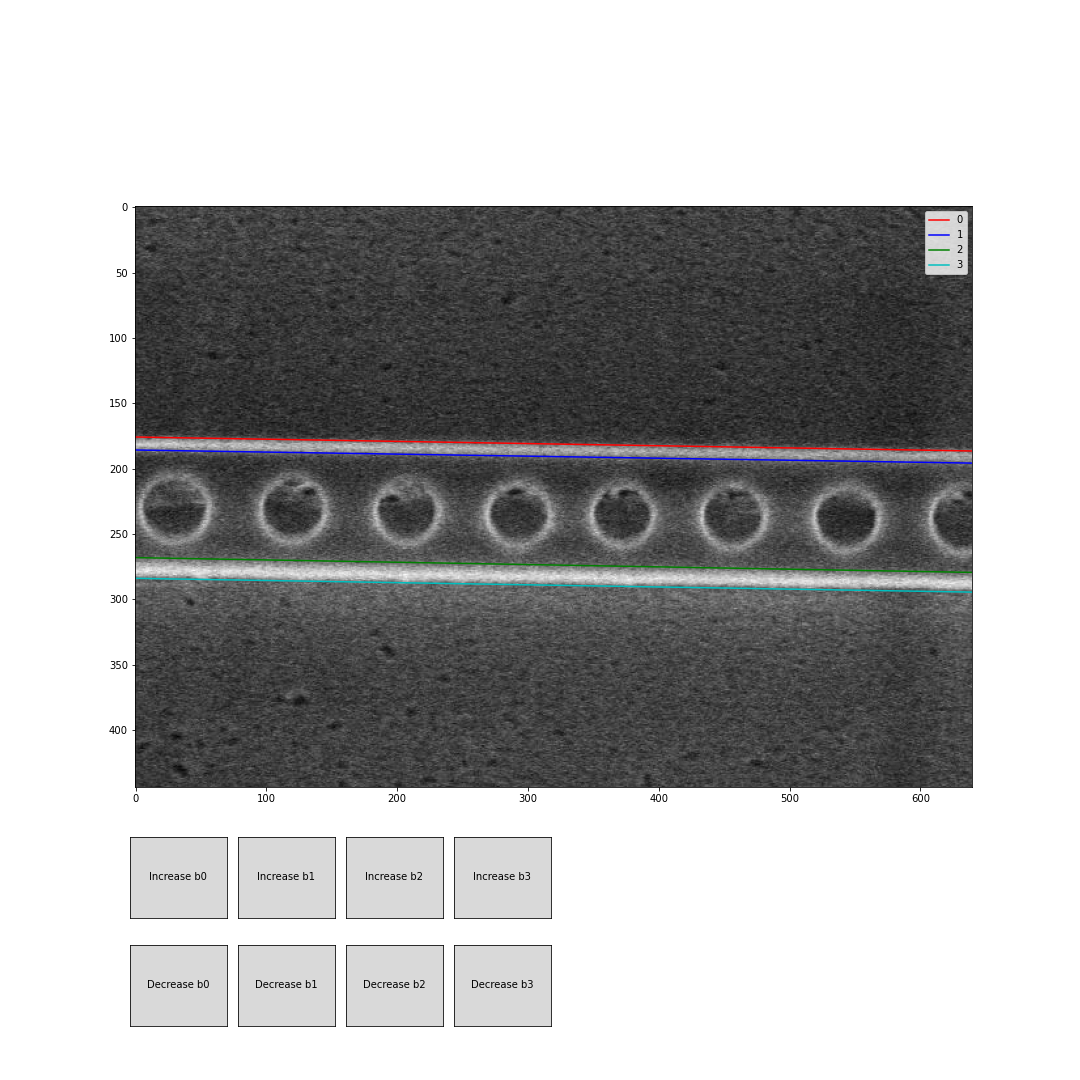

In [11]:
%matplotlib widget

def add_line_to_plot(ax: plt.Axes, img: np.ndarray, m: float, b: float, color: str = "r", label: str = ""):
    """
    Add a line to a matplotlib plot.
    """
    x = np.arange(0, img.shape[1])
    y = m * x + b
    return ax.plot(x, y, color=color, label=label)


class UpdateButtons:
    def __init__(self, ind: int, ax_up: plt.Axes, ax_down: plt.Axes, line: plt.Artist, m: float, b: float) -> None:
        self._ind = ind
        self._ax_up = ax_up
        self._ax_down = ax_down
        self._line = line
        self._m = m
        self._b = b

        self.button_up = widgets.Button(self._ax_up, f"Increase b{self._ind}")
        self.button_up.on_clicked(self.increase_b)

        self.button_down = widgets.Button(self._ax_down, f"Decrease b{self._ind}")
        self.button_down.on_clicked(self.decrease_b)

    @property
    def m(self):
        return self._m

    @property
    def b(self):
        return self._b

    @property
    def ind(self):
        return self._ind

    def redraw_line(self) -> None:
        self._line.set_ydata(self._m * self._line.get_xdata() + self._b)
        plt.draw()

    def increase_b(self, event) -> None:
        self._b += 1
        self.redraw_line()

    def decrease_b(self, event) -> None:
        self._b -= 1
        self.redraw_line()


# Setup plot
tuned_lines = center_sorted.copy()
fig, ax = plt.subplots(figsize=(15, 15))
plt.subplots_adjust(bottom=0.2)

# Show image and plot lines
ax.imshow(no_banner, cmap="gray")

ax_lines = []
colors = ["r", "b", "g", "c"]
for i in range(4):
    m, b = tuned_lines[i]
    c = colors[i]
    label = i
    l, = add_line_to_plot(ax, no_banner, m, b, c, label)
    ax_lines.append(l)

# Add buttons to plot
btns_list = []
for i in range(4):
    btn_ax_up = plt.axes([0.12 + 0.1*i, 0.15, 0.09, 0.075])
    btn_ax_down = plt.axes([0.12 + 0.1*i, 0.05, 0.09, 0.075])
    btns = UpdateButtons(i, btn_ax_up, btn_ax_down, ax_lines[i], tuned_lines[i][0], tuned_lines[i][1])
    btns_list.append(btns)

ax.legend()
plt.show()

# Get Distances

In [12]:
def find_distances(btns_list: List[UpdateButtons]) -> Dict[Tuple[int, int], float]:
    # Use the average slope of all of the line. Since the slopes are basically 
    # all the same, it doesn't really matter anyways.
    m = np.mean([btn.m for btn in btns_list])
    b = [btn.b for btn in btns_list]
    
    # Loop through all pairs of b values and find the distances
    distances = {}
    for (i, j) in combinations(range(len(b)), 2): 
        distances[(i, j)] = abs(b[i] - b[j]) / np.sqrt(1 + m**2)

    return distances
        
distances = find_distances(btns_list)
distances

{(0, 1): 9.953000797555093,
 (0, 2): 92.20428388039322,
 (0, 3): 108.04441057851729,
 (1, 2): 82.25128308283813,
 (1, 3): 98.0914097809622,
 (2, 3): 15.840126698124065}

In [13]:
scale = get_pixel_size(filename, ".txt")
distances_scaled = {(i, j): d * scale for (i, j), d in distances.items()}
distances_scaled

{(0, 1): 56.429961300852646,
 (0, 2): 522.7653726724842,
 (0, 3): 612.5732361256164,
 (1, 2): 466.3354113716316,
 (1, 3): 556.1432748247638,
 (2, 3): 89.80786345313221}